1. Implement a solver for the shallow water equations, 
$$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$ 
where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential. The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.
2. Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.
3. The total energy in the system is kinetic plus potential energy $$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$ Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.
4. Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL? Does it depend on your choice of limiter in slope reconstruction?

## 1)

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import animation
from IPython.display import HTML
pyplot.style.use('ggplot')

%run fdtools.py

In [2]:
g = 1 # m/s

def flux_shallow_water(U):
    h = U[0]
    u = U[1] / h
    return numpy.array([U[1], U[1]*u + (g/2)*h**2])

In [3]:
limiters = []
def limappend(lim):
    limiters.append(lim)
    return lim

@limappend
def limit_zero(r):
    return 0*r

@limappend
def limit_none(r):
    return 0*r+1

@limappend
def limit_minmod(r):
    return numpy.maximum(numpy.minimum(2*r, 2*(1-r)), 0)

@limappend
def limit_sin(r):
    return numpy.where(numpy.all((0 < r, r < 1), axis=0),
                      numpy.sin(numpy.pi*r),
                      0)

@limappend
def limit_vl(r):
    return numpy.maximum(4*r*(1-r), 0)

@limappend
def limit_bj(r):
    return numpy.clip(numpy.minimum(4*r, 4*(1-r)), 0, 1)

In [30]:
def riemann_shallow_hll(UL, UR):
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
    for i in range(len(hL)):
        if hL[i]<0 or hR[i]<0:
            print('negative h:', hL[i], hR[i], i)
            exit()
    c = lambda h: numpy.sqrt(g*h)
    sL = numpy.minimum(uL - c(hL) , uR - c(hR))
    sR = numpy.minimum(uL + c(hL) , uR + c(hR))
    fL = flux_shallow_water(UL)
    fR = flux_shallow_water(UR)
    return numpy.where(sL > 0, fL,
                       numpy.where(sR < 0, fR,
                                   (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))

def riemann_shallow_rusanov(UL, UR):
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
    for i in range(len(hL)):
        if hL[i]<0 or hR[i]<0:
            print('negative h:', hL[i], hR[i], i)
    c = lambda h: numpy.sqrt(g*h)
    sR = numpy.minimum(uL + c(hL) , uR + c(hR))
    sL = -sR
    fL = flux_shallow_water(UL)
    fR = flux_shallow_water(UR)
    return numpy.where(sL > 0, fL,
                       numpy.where(sR < 0, fR,
                                   (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))
#     return numpy.where(sL > 0, fL,
#                        numpy.where(sR < 0, fR,
#                                    (0.5*(fL - fR) - 0.5*sR*(UR - UL))))

In [5]:
def fvsolve2system(riemann, U0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod, args = ()):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=h/10, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

In [6]:
initials = []
def initialappend(init):
    initials.append(init)
    return init

@initialappend
def init_test_sharp(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2)>0.5),0*x])

@initialappend
def init_test_smooth(x):
    return numpy.array([1 + 0.5*(numpy.exp(-(x)**2/0.5)),0*x])

@initialappend
def init_shock_shock(x):
    u = -0.5*numpy.sign(x)
    return numpy.array([1+0*x, u])

@initialappend
def init_rarifaction_rarifaction(x):
    u = 0.5*numpy.sign(x)
    return numpy.array([1+0*x, u])

@initialappend
def init_shock_rarifaction(x):
    h = -numpy.sign(x)+2
    return numpy.array([h, 0*x])

@initialappend
def init_rarifaction_shock(x):
    h = numpy.sign(x)+2
    return numpy.array([h, 0*x])




601


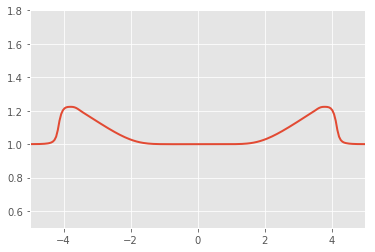

In [7]:
x, hist = fvsolve2system(riemann_shallow_hll, init_test_smooth,a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)
print(len(hist))

fig = pyplot.figure()
ax = pyplot.axes(xlim=(-5, 5), ylim=(0.5, 1.8))
line, = ax.plot([], [], lw=2)
# for animation
def init():
    line.set_data([], [])
    return line,
def animate_height(i):
    t, U = hist[i]
    line.set_data(x, U[0])
    return line,
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_height, init_func=init,
                               frames=len(hist), interval=30, blit=True)
HTML(anim.to_html5_video())

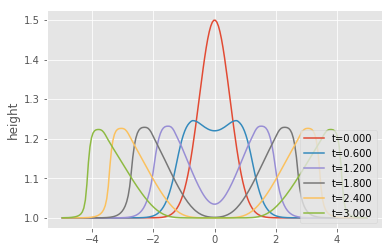

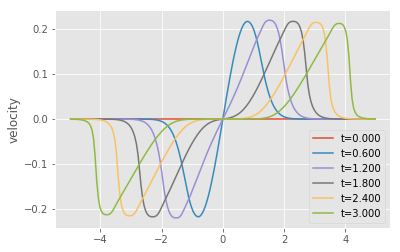

In [8]:
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

601


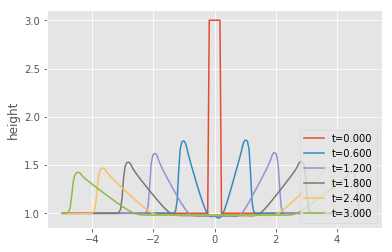

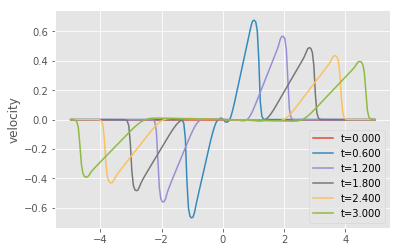

In [9]:
x, hist = fvsolve2system(riemann_shallow_hll, init_test_sharp,a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)
print(len(hist))

for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

## 2) All possible configurations of shocks and rarifactions
Different initial condition:
1. 2 outgoing shocks:
    $$h_L = h_R, u_R = -u_L < 0$$
2. 2 outgoing rarifaction:
    $$h_L = h_R, u_R = -u_L > 0$$
    
3. rarifaction and shock:
    $$u_L = u_R = 0, h_R<h_L$$
4. shock and rarifaction:
    $$u_L = u_R = 0, h_R>h_L$$

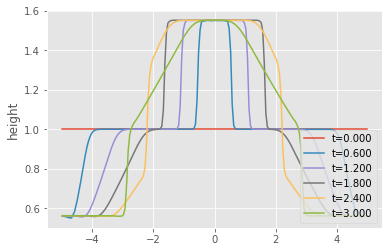

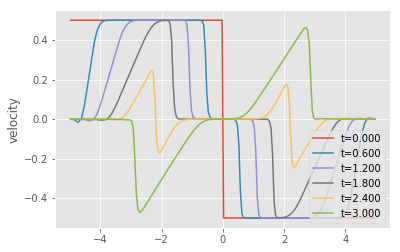

In [10]:
x, hist = fvsolve2system(riemann_shallow_hll, init_shock_shock,a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)

for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

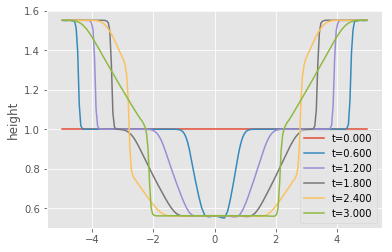

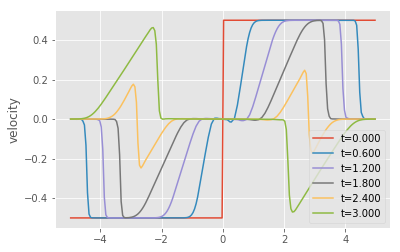

In [11]:
x, hist = fvsolve2system(riemann_shallow_hll, init_rarifaction_rarifaction,a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)

for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

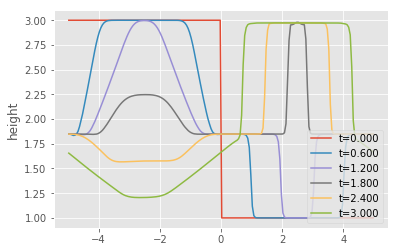

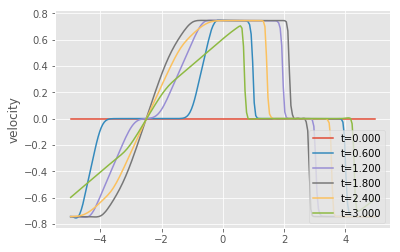

In [12]:
x, hist = fvsolve2system(riemann_shallow_hll, init_shock_rarifaction,a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)

for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

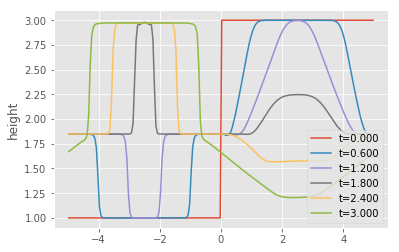

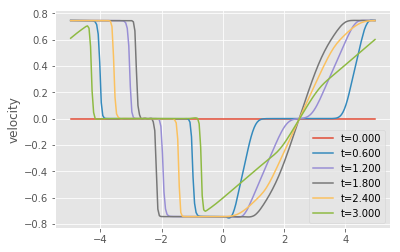

In [13]:
x, hist = fvsolve2system(riemann_shallow_hll, init_rarifaction_shock,a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)

for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

## 3) Energy

In [14]:
energy = lambda u: numpy.sum(u[0]*u[1]**2/2+g*u[0]**2/2)

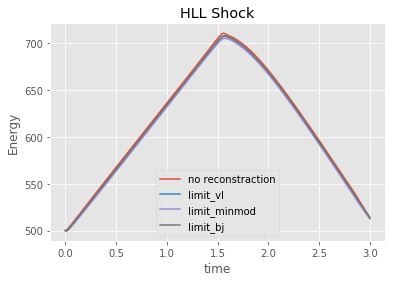

In [27]:
x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_shock,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_none)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)
pyplot.plot(T, E, label='no reconstraction')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_shock,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_vl)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_vl') 


x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_shock,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_minmod')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_shock,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_bj)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_bj')

pyplot.title('HLL Shock')
pyplot.xlabel('time')
pyplot.ylabel('Energy')
pyplot.legend();

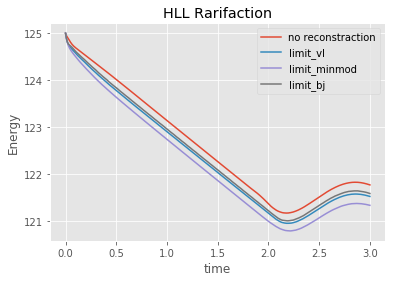

In [24]:
x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_none)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)
pyplot.plot(T, E, label='no reconstraction')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_vl)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_vl') 


x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_minmod')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_bj)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_bj')

pyplot.title('HLL Rarifaction')
pyplot.xlabel('time')
pyplot.ylabel('Energy')
pyplot.legend();

In [ ]:
## 4)

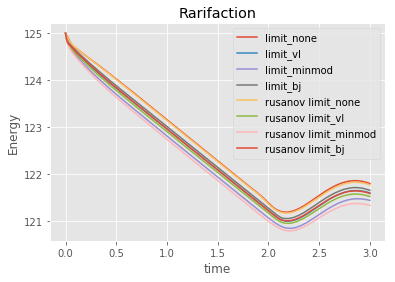

In [35]:
x, hist = fvsolve2system(riemann_shallow_rusanov,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_none)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)
pyplot.plot(T, E, label='limit_none')

x, hist = fvsolve2system(riemann_shallow_rusanov,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_vl)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_vl') 


x, hist = fvsolve2system(riemann_shallow_rusanov,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_minmod')

x, hist = fvsolve2system(riemann_shallow_rusanov,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_bj)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='limit_bj')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_none)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)
pyplot.plot(T, E, label='rusanov limit_none')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_vl)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='rusanov limit_vl') 


x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_minmod)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='rusanov limit_minmod')

x, hist = fvsolve2system(riemann_shallow_hll,init_rarifaction_rarifaction,
                         a=-5, b=5, tfinal=3., n=200, limit=limit_bj)
E = []
T = []
for t, U in hist:
    E.append(energy(U))
    T.append(t)    
pyplot.plot(T, E, label='rusanov limit_bj')

pyplot.title('Rarifaction')
pyplot.xlabel('time')
pyplot.ylabel('Energy')
pyplot.legend();